In [1]:
!pip install pytorch_model_summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [17]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
import time
from torch import nn, optim
from tqdm import tqdm
from pytorch_model_summary import summary
import pickle

In [41]:
import torch
from torch.optim import Optimizer
import math
from collections import defaultdict

class AdamSGDWeighted(Optimizer):
    r"""Implements Adam, SGD and DFE mix algorithm.
    """

    def __init__(self,
                 params, lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,
                 adam_w=0.3, sgd_w=0.3, transform='linear'):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,
            adam_w=adam_w, sgd_w=sgd_w
        )
        super(AdamSGDWeighted, self).__init__(params, defaults)
        self.eps = eps
        self.transform = transform
    def __setstate__(self, state):
        super(AdamSGDWeighted, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('AdamSGDDFEWeighted does not support sparse gradients')

                d_p_adam, step_size = self.adam_step(grad, group, p)

                d_p_sgd = self.sgd_step(grad, group, p)
                
                if self.transform == 'polynomial':
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * (d_p_adam**2 + d_p_adam) 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )

                elif self.transform == 'linear':
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )

                elif self.transform == 'correction':
                    
                    if torch.sum(d_p_sgd * d_p_adam) > 0: 
                        megred_d_p = group['sgd_w'] * d_p_sgd 
                        merged_lr = group['sgd_w'] * group['lr'] 
                    else:
                        megred_d_p = group['adam_w'] * d_p_adam 
                        merged_lr = group['adam_w'] * step_size 

                    merged_lr = group['sgd_w'] * group['lr'] + group['adam_w'] * step_size 

                elif self.transform == 'normalized':
                    megred_d_p = group['adam_w'] * torch.norm(d_p_adam) * d_p_sgd/torch.norm(d_p_sgd)  
                    
                    merged_lr = group['sgd_w'] * group['lr']

                elif self.transform == 'vector_combine':
                    d_p_sgd[d_p_sgd.shape[0]//2:] = 0
                    d_p_adam[:d_p_sgd.shape[0]//2] = 0
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )/2

                p.add_(megred_d_p, alpha=-merged_lr)

        return loss

    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p
    

In [19]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 32, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(32, 64, 5)
        # self.fc1 = nn.Linear(64 * 5 * 5, 312)
        # self.fc2 = nn.Linear(312, 84)

        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 312),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(312, 84),
            nn.Dropout(),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.base(x)
        x = self.fc3(x)
        return x

In [21]:
def train(model,trainloader,testloader, nb_epochs = 100, eta = 1e-3, adam_w=0.5, sgd_w=0.5, transform='linear', mix='Mix'):
    
    criterion = nn.CrossEntropyLoss()
    if mix == 'Mix':
      optimizer = AdamSGDWeighted(model.parameters(), lr=eta, momentum=0, adam_w=adam_w, sgd_w=sgd_w, transform=transform)
    elif mix == 'Adam':
      optimizer = optim.Adam(cnn.parameters(), lr=eta)
    elif mix == 'SGD':
      optimizer = optim.SGD(cnn.parameters(), lr=eta, momentum=0.9)

    acc_val = []
    loss_train = []
    loss_val = []

    for e in range(nb_epochs):
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda() # add this line
            outputs = model(inputs)

            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            if mix == 'Mix': 
              optimizer.step(lambda: float(loss))
            else:
              optimizer.step()

            # print statistics
            running_loss += loss.item()
            rep = 2000
            if i % rep == 1999:    # print every 2000 mini-batches
                loss_train.append(running_loss/rep)
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / rep))
                running_loss = 0.0
                correct = 0
                total = 0
                # since we're not training, we don't need to calculate the gradients for our outputs
                with torch.no_grad():
                    rloss_val = 0
                    for data in testloader:
                        images, labels = data
                        images, labels = images.cuda(), labels.cuda()

                        # calculate outputs by running images through the network
                        outputs = model(images)
                        rloss = criterion(outputs, labels)
                        rloss_val += rloss.item()

                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %d %%' % (
                    100 * correct / total))
                acc_val.append(correct / total)
                loss_val.append(rloss_val/ total)
    return acc_val, loss_val



In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np


# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

runs = 10
root_save = './Logs/'

In [23]:
device

device(type='cuda')

### Baseline

In [24]:
# SGD
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc = []
histories_loss = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, mix='SGD')
    histories_acc.append(history_acc)
    histories_loss.append(history_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 2.048
Accuracy of the network on the 10000 test images: 33 %
[2,  2000] loss: 1.651
Accuracy of the network on the 10000 test images: 42 %
[3,  2000] loss: 1.499
Accuracy of the network on the 10000 test images: 46 %
[4,  2000] loss: 1.401
Accuracy of the network on the 10000 test images: 49 %


KeyboardInterrupt: 

In [12]:
with open(root_save+'sgd_acc.pkl','wb') as f:
  pickle.dump(histories_acc, f)

with open(root_save+'sgd_loss.pkl','wb') as f:
  pickle.dump(histories_loss, f)


NameError: name 'histories_acc' is not defined

In [ ]:
# Adam
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc0 = []
histories_loss0 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in range(runs):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 50, eta=lr, adam_w=alpha, sgd_w=1-alpha, mix='Adam')
    histories_acc0.append(history_acc)
    histories_loss0.append(history_loss)

Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy o

In [ ]:
with open(root_save+'adam_acc.pkl','wb') as f:
  pickle.dump(histories_acc0, f)

with open(root_save+'adam_loss.pkl','wb') as f:
  pickle.dump(histories_loss0, f)


### Linear combination

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='linear')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  1000] loss: 1.576
Accuracy of the network on the 10000 test images: 53 %
[1,  2000] loss: 1.278
Accuracy of the network on the 10000 test images: 54 %
[2,  1000] loss: 1.013
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 64 %
[3,  1000] loss: 0.838
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.833
Accuracy of the network on the 10000 test images: 65 %
[4,  1000] loss: 0.683
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.732
Accuracy of the network on the 10000 test images: 66 %
[5,  1000] loss: 0.565
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.614
Accuracy of the network on the 10000 test images: 69 %
[6,  1000] loss: 0.480
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.522
Accuracy of the network on the 10000 test images: 68 %
[7,  1000] loss: 0.396
Accura

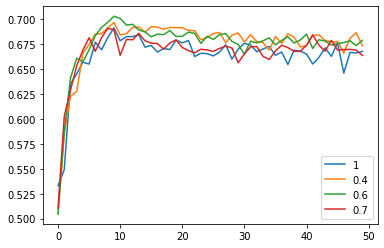

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc1 = []
histories_loss1 = []

lr = 1e-3
alpha = 0.6
batch_size = 256


for i in range(runs):

    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 50, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='linear')
    histories_acc1.append(history_acc)
    histories_loss1.append(history_loss)

[1,  1000] loss: 1.575
Accuracy of the network on the 10000 test images: 52 %
[1,  2000] loss: 1.265
Accuracy of the network on the 10000 test images: 56 %
[2,  1000] loss: 1.006
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 0.980
Accuracy of the network on the 10000 test images: 63 %
[3,  1000] loss: 0.805
Accuracy of the network on the 10000 test images: 67 %
[3,  2000] loss: 0.797
Accuracy of the network on the 10000 test images: 68 %
[4,  1000] loss: 0.642
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.679
Accuracy of the network on the 10000 test images: 67 %
[5,  1000] loss: 0.507
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.556
Accuracy of the network on the 10000 test images: 68 %
[6,  1000] loss: 0.405
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.457
Accuracy of the network on the 10000 test images: 69 %
[7,  1000] loss: 0.318
Accuracy of the network on the 10000 test

In [ ]:
with open(root_save+'linear_acc.pkl','wb') as f:
  pickle.dump(histories_acc1, f)

with open(root_save+'linear_loss.pkl','wb') as f:
  pickle.dump(histories_loss1, f)


### Polynomial Combination

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='polynomial')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  1000] loss: 1.762
Accuracy of the network on the 10000 test images: 40 %
[1,  2000] loss: 1.679
Accuracy of the network on the 10000 test images: 39 %
[2,  1000] loss: 1.891
Accuracy of the network on the 10000 test images: 21 %
[2,  2000] loss: 1.889
Accuracy of the network on the 10000 test images: 35 %
[3,  1000] loss: 1.996
Accuracy of the network on the 10000 test images: 25 %
[3,  2000] loss: 2.064
Accuracy of the network on the 10000 test images: 15 %
[4,  1000] loss: 2.216
Accuracy of the network on the 10000 test images: 16 %
[4,  2000] loss: 2.240
Accuracy of the network on the 10000 test images: 15 %
[5,  1000] loss: 2.252
Accuracy of the network on the 10000 test images: 14 %
[5,  2000] loss: 2.261
Accuracy of the network on the 10000 test images: 15 %
[6,  1000] loss: 2.258
Accuracy of the network on the 10000 test images: 15 %
[6,  2000] loss: 2.250
Accuracy of the network on the 10000 test images: 15 %
[7,  1000] loss: 2.263
Accura

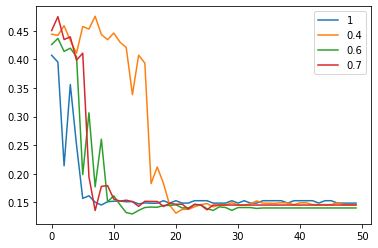

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

### Correction

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='correction')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  2000] loss: 1.436
Accuracy of the network on the 10000 test images: 55 %
[2,  2000] loss: 1.024
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.842
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.709
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.602
Accuracy of the network on the 10000 test images: 66 %
[6,  2000] loss: 0.501
Accuracy of the network on the 10000 test images: 66 %
[7,  2000] loss: 0.436
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.369
Accuracy of the network on the 10000 test images: 66 %
[9,  2000] loss: 0.325
Accuracy of the network on the 10000 test images: 66 %
[10,  2000] loss: 0.293
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.267
Accuracy of the network on the 10000 test images: 66 %
[12,  2000] loss: 0.237
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.231
Ac

In [ ]:
val_accuracies = np.array(histories)[:,0,:]
val_losses = np.array(histories)[:,1,:]

In [ ]:
plt.style.use('seaborn-whitegrid')
colors = ['lightcoral','palegreen','lightskyblue','plum']

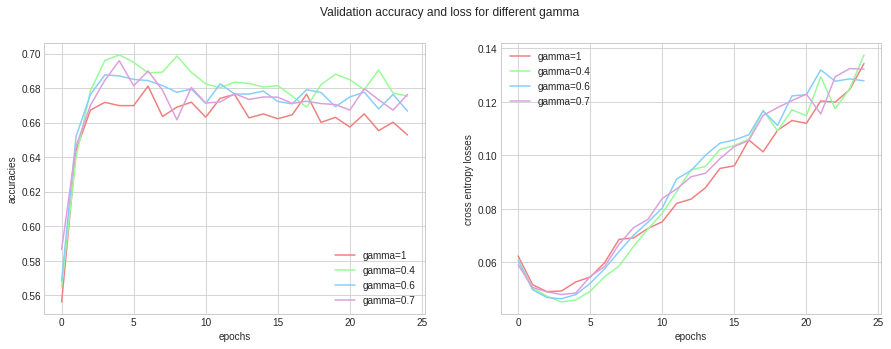

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(4):
    ax[0].plot(range(len(val_accuracies[i])),val_accuracies[i], label='gamma='+str(alphas[i]), color=colors[i])
    ax[1].plot(range(len(val_losses[i])),val_losses[i], label='gamma='+str(alphas[i]), color=colors[i])



ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracies')

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('cross entropy losses')

ax[0].legend()
ax[1].legend()
plt.suptitle('Validation accuracy and loss for different gamma')
plt.show()

In [45]:
from tqdm import tqdm

In [46]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc2 = []
histories_loss2 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='correction')
    histories_acc2.append(history_acc)
    histories_loss2.append(history_loss)








  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 2.302
Accuracy of the network on the 10000 test images: 11 %
[2,  2000] loss: 2.291
Accuracy of the network on the 10000 test images: 15 %
[3,  2000] loss: 2.268
Accuracy of the network on the 10000 test images: 18 %
[4,  2000] loss: 2.193
Accuracy of the network on the 10000 test images: 22 %
[5,  2000] loss: 2.108
Accuracy of the network on the 10000 test images: 24 %
[6,  2000] loss: 2.046
Accuracy of the network on the 10000 test images: 25 %
[7,  2000] loss: 2.000
Accuracy of the network on the 10000 test images: 28 %
[8,  2000] loss: 1.954
Accuracy of the network on the 10000 test images: 30 %
[9,  2000] loss: 1.901
Accuracy of the network on the 10000 test images: 31 %
[10,  2000] loss: 1.849
Accuracy of the network on the 10000 test images: 34 %
[11,  2000] loss: 1.804
Accuracy of the network on the 10000 test images: 35 %
[12,  2000] loss: 1.765
Accuracy of the network on the 10000 test images: 36 %
[13,  2000] loss: 1.723
Accuracy of the network on the 10000 








 10%|█         | 1/10 [40:37<6:05:40, 2437.85s/it]

[1,  2000] loss: 2.299
Accuracy of the network on the 10000 test images: 11 %
[2,  2000] loss: 2.287
Accuracy of the network on the 10000 test images: 14 %
[3,  2000] loss: 2.260
Accuracy of the network on the 10000 test images: 17 %
[4,  2000] loss: 2.210
Accuracy of the network on the 10000 test images: 21 %
[5,  2000] loss: 2.134
Accuracy of the network on the 10000 test images: 23 %
[6,  2000] loss: 2.063
Accuracy of the network on the 10000 test images: 26 %
[7,  2000] loss: 2.009
Accuracy of the network on the 10000 test images: 27 %
[8,  2000] loss: 1.955
Accuracy of the network on the 10000 test images: 30 %
[9,  2000] loss: 1.898
Accuracy of the network on the 10000 test images: 31 %
[10,  2000] loss: 1.849
Accuracy of the network on the 10000 test images: 33 %
[11,  2000] loss: 1.801
Accuracy of the network on the 10000 test images: 35 %
[12,  2000] loss: 1.759
Accuracy of the network on the 10000 test images: 37 %
[13,  2000] loss: 1.713
Accuracy of the network on the 10000 








 20%|██        | 2/10 [1:20:56<5:24:16, 2432.05s/it]

[1,  2000] loss: 2.301
Accuracy of the network on the 10000 test images: 12 %
[2,  2000] loss: 2.290
Accuracy of the network on the 10000 test images: 15 %
[3,  2000] loss: 2.261
Accuracy of the network on the 10000 test images: 18 %
[4,  2000] loss: 2.197
Accuracy of the network on the 10000 test images: 20 %
[5,  2000] loss: 2.116
Accuracy of the network on the 10000 test images: 22 %
[6,  2000] loss: 2.051
Accuracy of the network on the 10000 test images: 26 %
[7,  2000] loss: 2.003
Accuracy of the network on the 10000 test images: 27 %
[8,  2000] loss: 1.950
Accuracy of the network on the 10000 test images: 29 %
[9,  2000] loss: 1.896
Accuracy of the network on the 10000 test images: 32 %
[10,  2000] loss: 1.848
Accuracy of the network on the 10000 test images: 33 %
[11,  2000] loss: 1.796
Accuracy of the network on the 10000 test images: 35 %
[12,  2000] loss: 1.757
Accuracy of the network on the 10000 test images: 37 %
[13,  2000] loss: 1.714
Accuracy of the network on the 10000 








 30%|███       | 3/10 [2:01:19<4:43:25, 2429.43s/it]

[1,  2000] loss: 2.303
Accuracy of the network on the 10000 test images: 11 %
[2,  2000] loss: 2.292
Accuracy of the network on the 10000 test images: 14 %
[3,  2000] loss: 2.270
Accuracy of the network on the 10000 test images: 17 %
[4,  2000] loss: 2.215
Accuracy of the network on the 10000 test images: 19 %
[5,  2000] loss: 2.128
Accuracy of the network on the 10000 test images: 22 %
[6,  2000] loss: 2.054
Accuracy of the network on the 10000 test images: 25 %
[7,  2000] loss: 2.002
Accuracy of the network on the 10000 test images: 27 %
[8,  2000] loss: 1.941
Accuracy of the network on the 10000 test images: 30 %
[9,  2000] loss: 1.882
Accuracy of the network on the 10000 test images: 32 %
[10,  2000] loss: 1.849
Accuracy of the network on the 10000 test images: 34 %
[11,  2000] loss: 1.785
Accuracy of the network on the 10000 test images: 35 %
[12,  2000] loss: 1.746
Accuracy of the network on the 10000 test images: 36 %
[13,  2000] loss: 1.713
Accuracy of the network on the 10000 








 40%|████      | 4/10 [2:41:26<4:02:16, 2422.79s/it]

[1,  2000] loss: 2.298
Accuracy of the network on the 10000 test images: 12 %
[2,  2000] loss: 2.284
Accuracy of the network on the 10000 test images: 15 %
[3,  2000] loss: 2.240
Accuracy of the network on the 10000 test images: 18 %
[4,  2000] loss: 2.156
Accuracy of the network on the 10000 test images: 21 %
[5,  2000] loss: 2.077
Accuracy of the network on the 10000 test images: 23 %
[6,  2000] loss: 2.027
Accuracy of the network on the 10000 test images: 26 %
[7,  2000] loss: 1.985
Accuracy of the network on the 10000 test images: 28 %
[8,  2000] loss: 1.934
Accuracy of the network on the 10000 test images: 31 %
[9,  2000] loss: 1.885
Accuracy of the network on the 10000 test images: 31 %
[10,  2000] loss: 1.842
Accuracy of the network on the 10000 test images: 34 %
[11,  2000] loss: 1.794
Accuracy of the network on the 10000 test images: 35 %
[12,  2000] loss: 1.753
Accuracy of the network on the 10000 test images: 36 %
[13,  2000] loss: 1.718
Accuracy of the network on the 10000 








 50%|█████     | 5/10 [3:21:41<3:21:42, 2420.42s/it]

[1,  2000] loss: 2.301
Accuracy of the network on the 10000 test images: 11 %
[2,  2000] loss: 2.291
Accuracy of the network on the 10000 test images: 14 %
[3,  2000] loss: 2.266
Accuracy of the network on the 10000 test images: 17 %
[4,  2000] loss: 2.201
Accuracy of the network on the 10000 test images: 20 %
[5,  2000] loss: 2.118
Accuracy of the network on the 10000 test images: 23 %
[6,  2000] loss: 2.053
Accuracy of the network on the 10000 test images: 25 %
[7,  2000] loss: 2.003
Accuracy of the network on the 10000 test images: 27 %
[8,  2000] loss: 1.958
Accuracy of the network on the 10000 test images: 29 %
[9,  2000] loss: 1.903
Accuracy of the network on the 10000 test images: 31 %
[10,  2000] loss: 1.855
Accuracy of the network on the 10000 test images: 33 %
[11,  2000] loss: 1.800
Accuracy of the network on the 10000 test images: 34 %
[12,  2000] loss: 1.755
Accuracy of the network on the 10000 test images: 36 %
[13,  2000] loss: 1.722
Accuracy of the network on the 10000 








 60%|██████    | 6/10 [4:01:58<2:41:16, 2419.16s/it]

[1,  2000] loss: 2.302
Accuracy of the network on the 10000 test images: 11 %
[2,  2000] loss: 2.296
Accuracy of the network on the 10000 test images: 13 %
[3,  2000] loss: 2.287
Accuracy of the network on the 10000 test images: 16 %
[4,  2000] loss: 2.256
Accuracy of the network on the 10000 test images: 18 %
[5,  2000] loss: 2.183
Accuracy of the network on the 10000 test images: 22 %
[6,  2000] loss: 2.105
Accuracy of the network on the 10000 test images: 24 %
[7,  2000] loss: 2.045
Accuracy of the network on the 10000 test images: 26 %
[8,  2000] loss: 2.002
Accuracy of the network on the 10000 test images: 28 %
[9,  2000] loss: 1.955
Accuracy of the network on the 10000 test images: 30 %
[10,  2000] loss: 1.905
Accuracy of the network on the 10000 test images: 31 %
[11,  2000] loss: 1.862
Accuracy of the network on the 10000 test images: 33 %
[12,  2000] loss: 1.818
Accuracy of the network on the 10000 test images: 34 %
[13,  2000] loss: 1.769
Accuracy of the network on the 10000 








 70%|███████   | 7/10 [4:42:31<2:01:10, 2423.34s/it]

[1,  2000] loss: 2.301
Accuracy of the network on the 10000 test images: 13 %
[2,  2000] loss: 2.287
Accuracy of the network on the 10000 test images: 16 %
[3,  2000] loss: 2.249
Accuracy of the network on the 10000 test images: 18 %
[4,  2000] loss: 2.167
Accuracy of the network on the 10000 test images: 21 %
[5,  2000] loss: 2.094
Accuracy of the network on the 10000 test images: 23 %
[6,  2000] loss: 2.042
Accuracy of the network on the 10000 test images: 25 %
[7,  2000] loss: 1.993
Accuracy of the network on the 10000 test images: 28 %
[8,  2000] loss: 1.940
Accuracy of the network on the 10000 test images: 30 %
[9,  2000] loss: 1.881
Accuracy of the network on the 10000 test images: 32 %
[10,  2000] loss: 1.836
Accuracy of the network on the 10000 test images: 34 %
[11,  2000] loss: 1.784
Accuracy of the network on the 10000 test images: 35 %
[12,  2000] loss: 1.744
Accuracy of the network on the 10000 test images: 37 %
[13,  2000] loss: 1.705
Accuracy of the network on the 10000 








 80%|████████  | 8/10 [5:23:11<1:20:56, 2428.37s/it]

[1,  2000] loss: 2.304
Accuracy of the network on the 10000 test images: 11 %
[2,  2000] loss: 2.295
Accuracy of the network on the 10000 test images: 12 %
[3,  2000] loss: 2.281
Accuracy of the network on the 10000 test images: 16 %
[4,  2000] loss: 2.241
Accuracy of the network on the 10000 test images: 19 %
[5,  2000] loss: 2.169
Accuracy of the network on the 10000 test images: 21 %
[6,  2000] loss: 2.085
Accuracy of the network on the 10000 test images: 24 %
[7,  2000] loss: 2.024
Accuracy of the network on the 10000 test images: 27 %
[8,  2000] loss: 1.972
Accuracy of the network on the 10000 test images: 29 %
[9,  2000] loss: 1.915
Accuracy of the network on the 10000 test images: 31 %
[10,  2000] loss: 1.860
Accuracy of the network on the 10000 test images: 32 %
[11,  2000] loss: 1.822
Accuracy of the network on the 10000 test images: 34 %
[12,  2000] loss: 1.784
Accuracy of the network on the 10000 test images: 35 %
[13,  2000] loss: 1.740
Accuracy of the network on the 10000 








 90%|█████████ | 9/10 [6:03:17<40:21, 2421.76s/it]  

[1,  2000] loss: 2.302
Accuracy of the network on the 10000 test images: 12 %
[2,  2000] loss: 2.290
Accuracy of the network on the 10000 test images: 14 %
[3,  2000] loss: 2.264
Accuracy of the network on the 10000 test images: 17 %
[4,  2000] loss: 2.190
Accuracy of the network on the 10000 test images: 21 %
[5,  2000] loss: 2.120
Accuracy of the network on the 10000 test images: 24 %
[6,  2000] loss: 2.058
Accuracy of the network on the 10000 test images: 24 %
[7,  2000] loss: 2.012
Accuracy of the network on the 10000 test images: 27 %
[8,  2000] loss: 1.960
Accuracy of the network on the 10000 test images: 29 %
[9,  2000] loss: 1.913
Accuracy of the network on the 10000 test images: 30 %
[10,  2000] loss: 1.856
Accuracy of the network on the 10000 test images: 32 %
[11,  2000] loss: 1.808
Accuracy of the network on the 10000 test images: 34 %
[12,  2000] loss: 1.765
Accuracy of the network on the 10000 test images: 36 %
[13,  2000] loss: 1.734
Accuracy of the network on the 10000 








100%|██████████| 10/10 [6:43:43<00:00, 2422.36s/it]


In [47]:
with open(root_save+'correction_acc.pkl','wb') as f:
  pickle.dump(histories_acc2, f)

with open(root_save+'correction_loss.pkl','wb') as f:
  pickle.dump(histories_loss2, f)


### Normalization

In [25]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='normalized')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  2000] loss: 2.305
Accuracy of the network on the 10000 test images: 10 %


KeyboardInterrupt: 

IndexError: list index out of range

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000004C69FF1828>
Traceback (most recent call last):
  File "C:\Users\laboleb\Anaconda3_64\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\laboleb\Anaconda3_64\lib\site-packages\torch\utils\data\dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


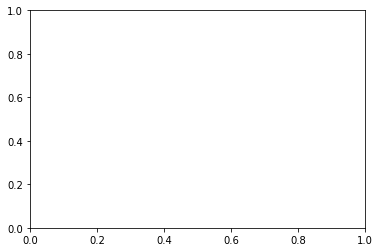

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

In [43]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc3 = []
histories_loss3 = []

lr = 2e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):

    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='normalized')
    histories_acc3.append(history_acc)
    histories_loss3.append(history_loss)








  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 1.862
Accuracy of the network on the 10000 test images: 40 %
[2,  2000] loss: 1.556
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.441
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.360
Accuracy of the network on the 10000 test images: 50 %
[5,  2000] loss: 1.293
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.241
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.192
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.148
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.114
Accuracy of the network on the 10000 test images: 60 %
[10,  2000] loss: 1.075
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.049
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.024
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 0.992
Accuracy of the network on the 10000 








 10%|█         | 1/10 [41:31<6:13:39, 2491.08s/it]

[1,  2000] loss: 1.872
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.564
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.453
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.370
Accuracy of the network on the 10000 test images: 52 %
[5,  2000] loss: 1.303
Accuracy of the network on the 10000 test images: 53 %
[6,  2000] loss: 1.240
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.191
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.145
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.108
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.066
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.041
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.014
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 0.980
Accuracy of the network on the 10000 








 20%|██        | 2/10 [1:22:59<5:32:03, 2490.41s/it]

[1,  2000] loss: 1.862
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.557
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.445
Accuracy of the network on the 10000 test images: 48 %
[4,  2000] loss: 1.366
Accuracy of the network on the 10000 test images: 52 %
[5,  2000] loss: 1.302
Accuracy of the network on the 10000 test images: 53 %
[6,  2000] loss: 1.248
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.196
Accuracy of the network on the 10000 test images: 57 %
[8,  2000] loss: 1.162
Accuracy of the network on the 10000 test images: 58 %
[9,  2000] loss: 1.117
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.082
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.052
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.024
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 0.995
Accuracy of the network on the 10000 








 30%|███       | 3/10 [2:04:01<4:49:32, 2481.79s/it]

[1,  2000] loss: 1.873
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.562
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.446
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.364
Accuracy of the network on the 10000 test images: 51 %
[5,  2000] loss: 1.301
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.249
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.190
Accuracy of the network on the 10000 test images: 56 %
[8,  2000] loss: 1.154
Accuracy of the network on the 10000 test images: 58 %
[9,  2000] loss: 1.125
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.089
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.054
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.022
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.001
Accuracy of the network on the 10000 








 40%|████      | 4/10 [2:45:29<4:08:22, 2483.71s/it]

[1,  2000] loss: 1.879
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.567
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.451
Accuracy of the network on the 10000 test images: 48 %
[4,  2000] loss: 1.370
Accuracy of the network on the 10000 test images: 51 %
[5,  2000] loss: 1.302
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.239
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.194
Accuracy of the network on the 10000 test images: 57 %
[8,  2000] loss: 1.144
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.111
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.076
Accuracy of the network on the 10000 test images: 61 %
[11,  2000] loss: 1.042
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.017
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 0.999
Accuracy of the network on the 10000 








 50%|█████     | 5/10 [3:26:58<3:27:06, 2485.31s/it]

[1,  2000] loss: 1.873
Accuracy of the network on the 10000 test images: 40 %
[2,  2000] loss: 1.566
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.454
Accuracy of the network on the 10000 test images: 50 %
[4,  2000] loss: 1.373
Accuracy of the network on the 10000 test images: 52 %
[5,  2000] loss: 1.296
Accuracy of the network on the 10000 test images: 53 %
[6,  2000] loss: 1.242
Accuracy of the network on the 10000 test images: 55 %
[7,  2000] loss: 1.199
Accuracy of the network on the 10000 test images: 56 %
[8,  2000] loss: 1.150
Accuracy of the network on the 10000 test images: 57 %
[9,  2000] loss: 1.117
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.085
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.051
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.022
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 0.996
Accuracy of the network on the 10000 








 60%|██████    | 6/10 [4:08:16<2:45:31, 2482.92s/it]

[1,  2000] loss: 1.872
Accuracy of the network on the 10000 test images: 38 %
[2,  2000] loss: 1.572
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.453
Accuracy of the network on the 10000 test images: 48 %
[4,  2000] loss: 1.379
Accuracy of the network on the 10000 test images: 51 %
[5,  2000] loss: 1.303
Accuracy of the network on the 10000 test images: 53 %
[6,  2000] loss: 1.255
Accuracy of the network on the 10000 test images: 55 %
[7,  2000] loss: 1.207
Accuracy of the network on the 10000 test images: 56 %
[8,  2000] loss: 1.164
Accuracy of the network on the 10000 test images: 58 %
[9,  2000] loss: 1.122
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.087
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.066
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.037
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.001
Accuracy of the network on the 10000 








 70%|███████   | 7/10 [4:49:50<2:04:19, 2486.38s/it]

[1,  2000] loss: 1.858
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.552
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.440
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.357
Accuracy of the network on the 10000 test images: 51 %
[5,  2000] loss: 1.295
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.242
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.180
Accuracy of the network on the 10000 test images: 57 %
[8,  2000] loss: 1.146
Accuracy of the network on the 10000 test images: 58 %
[9,  2000] loss: 1.104
Accuracy of the network on the 10000 test images: 60 %
[10,  2000] loss: 1.076
Accuracy of the network on the 10000 test images: 59 %
[11,  2000] loss: 1.048
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.018
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 0.992
Accuracy of the network on the 10000 








 80%|████████  | 8/10 [5:30:54<1:22:38, 2479.49s/it]

[1,  2000] loss: 1.867
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.565
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.448
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.364
Accuracy of the network on the 10000 test images: 51 %
[5,  2000] loss: 1.295
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.237
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.182
Accuracy of the network on the 10000 test images: 57 %
[8,  2000] loss: 1.145
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.103
Accuracy of the network on the 10000 test images: 60 %
[10,  2000] loss: 1.067
Accuracy of the network on the 10000 test images: 61 %
[11,  2000] loss: 1.039
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.015
Accuracy of the network on the 10000 test images: 63 %
[13,  2000] loss: 0.986
Accuracy of the network on the 10000 








 90%|█████████ | 9/10 [6:12:28<41:23, 2483.85s/it]  

[1,  2000] loss: 1.875
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.580
Accuracy of the network on the 10000 test images: 45 %
[3,  2000] loss: 1.469
Accuracy of the network on the 10000 test images: 48 %
[4,  2000] loss: 1.387
Accuracy of the network on the 10000 test images: 51 %
[5,  2000] loss: 1.321
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.252
Accuracy of the network on the 10000 test images: 55 %
[7,  2000] loss: 1.214
Accuracy of the network on the 10000 test images: 57 %
[8,  2000] loss: 1.165
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.126
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.096
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.064
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.029
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 1.002
Accuracy of the network on the 10000 








100%|██████████| 10/10 [6:53:56<00:00, 2483.65s/it]


In [44]:
with open(root_save+'normalization_acc.pkl','wb') as f:
  pickle.dump(histories_acc3, f)

with open(root_save+'normalization_loss.pkl','wb') as f:
  pickle.dump(histories_loss3, f)


### Vector Combination

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='vector_combine')
    
    histories.append(history)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

In [29]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc4 = []
histories_loss4 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='vector_combine')
    histories_acc4.append(history_acc)
    histories_loss4.append(history_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 1.841
Accuracy of the network on the 10000 test images: 41 %
[2,  2000] loss: 1.521
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.417
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.332
Accuracy of the network on the 10000 test images: 52 %
[5,  2000] loss: 1.267
Accuracy of the network on the 10000 test images: 54 %
[6,  2000] loss: 1.221
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.176
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.141
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.103
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.078
Accuracy of the network on the 10000 test images: 61 %
[11,  2000] loss: 1.059
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.038
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.018
Accuracy of the network on the 10000 


 10%|█         | 1/10 [38:57<5:50:38, 2337.60s/it]

[1,  2000] loss: 1.848
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.539
Accuracy of the network on the 10000 test images: 47 %
[3,  2000] loss: 1.429
Accuracy of the network on the 10000 test images: 51 %
[4,  2000] loss: 1.345
Accuracy of the network on the 10000 test images: 53 %
[5,  2000] loss: 1.278
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.220
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.179
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.150
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.120
Accuracy of the network on the 10000 test images: 60 %
[10,  2000] loss: 1.090
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.065
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.039
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.022
Accuracy of the network on the 10000 


 20%|██        | 2/10 [1:17:04<5:09:37, 2322.24s/it]

[1,  2000] loss: 1.839
Accuracy of the network on the 10000 test images: 40 %
[2,  2000] loss: 1.541
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.426
Accuracy of the network on the 10000 test images: 50 %
[4,  2000] loss: 1.344
Accuracy of the network on the 10000 test images: 54 %
[5,  2000] loss: 1.271
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.221
Accuracy of the network on the 10000 test images: 57 %
[7,  2000] loss: 1.175
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.142
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.109
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.085
Accuracy of the network on the 10000 test images: 61 %
[11,  2000] loss: 1.055
Accuracy of the network on the 10000 test images: 61 %
[12,  2000] loss: 1.040
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 1.011
Accuracy of the network on the 10000 


 30%|███       | 3/10 [1:56:06<4:31:37, 2328.27s/it]

[1,  2000] loss: 1.840
Accuracy of the network on the 10000 test images: 42 %
[2,  2000] loss: 1.529
Accuracy of the network on the 10000 test images: 47 %
[3,  2000] loss: 1.425
Accuracy of the network on the 10000 test images: 50 %
[4,  2000] loss: 1.347
Accuracy of the network on the 10000 test images: 52 %
[5,  2000] loss: 1.287
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.245
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.196
Accuracy of the network on the 10000 test images: 56 %
[8,  2000] loss: 1.163
Accuracy of the network on the 10000 test images: 58 %
[9,  2000] loss: 1.140
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.113
Accuracy of the network on the 10000 test images: 58 %
[11,  2000] loss: 1.079
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.052
Accuracy of the network on the 10000 test images: 60 %
[13,  2000] loss: 1.037
Accuracy of the network on the 10000 


 40%|████      | 4/10 [2:35:37<3:54:06, 2341.05s/it]

[1,  2000] loss: 1.835
Accuracy of the network on the 10000 test images: 40 %
[2,  2000] loss: 1.526
Accuracy of the network on the 10000 test images: 47 %
[3,  2000] loss: 1.413
Accuracy of the network on the 10000 test images: 51 %
[4,  2000] loss: 1.334
Accuracy of the network on the 10000 test images: 54 %
[5,  2000] loss: 1.270
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.215
Accuracy of the network on the 10000 test images: 57 %
[7,  2000] loss: 1.174
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.144
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.122
Accuracy of the network on the 10000 test images: 60 %
[10,  2000] loss: 1.084
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.068
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.046
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.043
Accuracy of the network on the 10000 


 50%|█████     | 5/10 [3:14:51<3:15:25, 2345.07s/it]

[1,  2000] loss: 1.829
Accuracy of the network on the 10000 test images: 41 %
[2,  2000] loss: 1.527
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.412
Accuracy of the network on the 10000 test images: 52 %
[4,  2000] loss: 1.338
Accuracy of the network on the 10000 test images: 54 %
[5,  2000] loss: 1.264
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.220
Accuracy of the network on the 10000 test images: 55 %
[7,  2000] loss: 1.185
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.149
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.114
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.097
Accuracy of the network on the 10000 test images: 61 %
[11,  2000] loss: 1.057
Accuracy of the network on the 10000 test images: 59 %
[12,  2000] loss: 1.042
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.027
Accuracy of the network on the 10000 


 60%|██████    | 6/10 [3:53:40<2:36:01, 2340.31s/it]

[1,  2000] loss: 1.838
Accuracy of the network on the 10000 test images: 40 %
[2,  2000] loss: 1.537
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.415
Accuracy of the network on the 10000 test images: 50 %
[4,  2000] loss: 1.338
Accuracy of the network on the 10000 test images: 54 %
[5,  2000] loss: 1.265
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.218
Accuracy of the network on the 10000 test images: 56 %
[7,  2000] loss: 1.182
Accuracy of the network on the 10000 test images: 57 %
[8,  2000] loss: 1.145
Accuracy of the network on the 10000 test images: 58 %
[9,  2000] loss: 1.116
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.086
Accuracy of the network on the 10000 test images: 59 %
[11,  2000] loss: 1.075
Accuracy of the network on the 10000 test images: 59 %
[12,  2000] loss: 1.048
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.021
Accuracy of the network on the 10000 


 70%|███████   | 7/10 [4:32:33<1:56:54, 2338.08s/it]

[1,  2000] loss: 1.840
Accuracy of the network on the 10000 test images: 40 %
[2,  2000] loss: 1.529
Accuracy of the network on the 10000 test images: 47 %
[3,  2000] loss: 1.411
Accuracy of the network on the 10000 test images: 51 %
[4,  2000] loss: 1.331
Accuracy of the network on the 10000 test images: 53 %
[5,  2000] loss: 1.263
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.224
Accuracy of the network on the 10000 test images: 55 %
[7,  2000] loss: 1.175
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.146
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.112
Accuracy of the network on the 10000 test images: 60 %
[10,  2000] loss: 1.089
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.066
Accuracy of the network on the 10000 test images: 59 %
[12,  2000] loss: 1.049
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.024
Accuracy of the network on the 10000 


 80%|████████  | 8/10 [5:11:27<1:17:53, 2336.78s/it]

[1,  2000] loss: 1.838
Accuracy of the network on the 10000 test images: 41 %
[2,  2000] loss: 1.529
Accuracy of the network on the 10000 test images: 48 %
[3,  2000] loss: 1.406
Accuracy of the network on the 10000 test images: 51 %
[4,  2000] loss: 1.320
Accuracy of the network on the 10000 test images: 54 %
[5,  2000] loss: 1.263
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.209
Accuracy of the network on the 10000 test images: 57 %
[7,  2000] loss: 1.169
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.135
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.106
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.086
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.054
Accuracy of the network on the 10000 test images: 60 %
[12,  2000] loss: 1.044
Accuracy of the network on the 10000 test images: 62 %
[13,  2000] loss: 1.019
Accuracy of the network on the 10000 


 90%|█████████ | 9/10 [5:50:30<38:58, 2338.72s/it]  

[1,  2000] loss: 1.858
Accuracy of the network on the 10000 test images: 39 %
[2,  2000] loss: 1.554
Accuracy of the network on the 10000 test images: 46 %
[3,  2000] loss: 1.440
Accuracy of the network on the 10000 test images: 49 %
[4,  2000] loss: 1.348
Accuracy of the network on the 10000 test images: 53 %
[5,  2000] loss: 1.279
Accuracy of the network on the 10000 test images: 55 %
[6,  2000] loss: 1.214
Accuracy of the network on the 10000 test images: 57 %
[7,  2000] loss: 1.180
Accuracy of the network on the 10000 test images: 58 %
[8,  2000] loss: 1.141
Accuracy of the network on the 10000 test images: 59 %
[9,  2000] loss: 1.112
Accuracy of the network on the 10000 test images: 59 %
[10,  2000] loss: 1.083
Accuracy of the network on the 10000 test images: 60 %
[11,  2000] loss: 1.059
Accuracy of the network on the 10000 test images: 62 %
[12,  2000] loss: 1.032
Accuracy of the network on the 10000 test images: 61 %
[13,  2000] loss: 1.015
Accuracy of the network on the 10000 


100%|██████████| 10/10 [6:29:43<00:00, 2338.38s/it]


In [30]:
with open(root_save+'vector_acc.pkl','wb') as f:
  pickle.dump(histories_acc4, f)

with open(root_save+'vector_loss.pkl','wb') as f:
  pickle.dump(histories_loss4, f)


IndexError: list index out of range

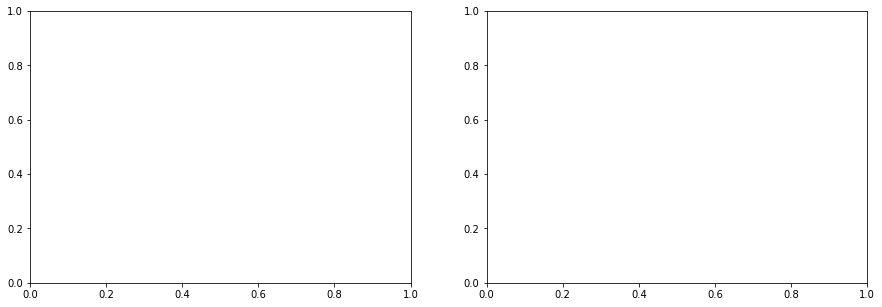

In [31]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(range(len(histories_acc[0])),histories_acc[0], label='SGD')
ax[0].plot(range(len(histories_acc0[0])),histories_acc0[0], label='Adam')
ax[0].plot(range(len(histories_acc1[0])),histories_acc1[0], label='Linear Combination MAS')

ax[1].plot(range(len(histories_acc[0])),histories_loss[0], label='SGD')
ax[1].plot(range(len(histories_acc0[0])),histories_loss0[0], label='Adam')
ax[1].plot(range(len(histories_acc1[0])),histories_loss1[0], label='Linear Combination MAS')

plt.suptitle('Validation accuracy and loss single-run across optimizers')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(range(len(histories_acc1[0])),histories_acc1[0], label='Linear Combination')
ax[0].plot(range(len(histories_acc0[0])),histories_acc2[0], label='Correction')
ax[0].plot(range(len(histories_acc[0])),histories_acc3[0], label='Normalization')
ax[0].plot(range(len(histories_acc[0])),histories_acc4[0], label='Vector Combination')

ax[1].plot(range(len(histories_acc1[0])),histories_loss1[0], label='Linear Combination')
ax[1].plot(range(len(histories_acc0[0])),histories_loss2[0], label='Correction')
ax[1].plot(range(len(histories_acc[0])),histories_loss3[0], label='Normalization')
ax[1].plot(range(len(histories_acc[0])),histories_loss4[0], label='Vector Combination')


plt.suptitle('Validation accuracy and loss single-run across optimizers')
plt.legend()
plt.show()